In [1]:
#https://medium.com/raposa-technologies/how-to-build-your-first-mean-reversion-trading-strategy-in-python-8c9d4813ee40
#https://medium.com/raposa-technologies/backtest-your-first-strategy-in-python-88f663aee95e

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [21]:
def SMAMeanReversion(ticker, sma, threshold, shorts=False,    start_date='2000-01-01', end_date='2020-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    data['SMA'] = data['Close'].rolling(sma).mean()
    data['extension'] = (data['Close'] - data['SMA']) / data['SMA']
    
    data['position'] = np.nan
    data['position'] = np.where(data['extension']<-threshold,
        1, data['position'])
    if shorts:
        data['position'] = np.where(
            data['extension']>threshold, -1, data['position'])
        
    data['position'] = np.where(np.abs(data['extension'])<0.01,
        0, data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    
    # Calculate returns and statistics
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * \
        data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * \
        data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns']  =   \
        np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data.dropna()

def getStratStats(data, risk_free_rate=0.02):
    sma_strat, buy_hold_strat = {}, {}
    
    # Total Returns
    sma_strat['tot_returns'] = np.exp(data['strat_log_returns'].sum()) - 1
    buy_hold_strat['tot_returns'] = np.exp(data['log_returns'].sum()) - 1
    
    # Mean Annual Returns
    sma_strat['annual_returns'] = np.exp(data['strat_log_returns'].mean() * 252) - 1
    buy_hold_strat['annual_returns'] = np.exp(data['log_returns'].mean() * 252) - 1
    
    # Annual Volatility
    sma_strat['annual_volatility'] = data['strat_log_returns'].std() * np.sqrt(252)
    buy_hold_strat['annual_volatility'] = data['log_returns'].std() * np.sqrt(252)
    
    # Sharpe Ratio
    sma_strat['sharpe_ratio'] = (sma_strat['annual_returns'] - risk_free_rate) \
        / sma_strat['annual_volatility']
    buy_hold_strat['sharpe_ratio'] = (buy_hold_strat['annual_returns'] - risk_free_rate) \
        / buy_hold_strat['annual_volatility']
    
    # Max Drawdown
    _strat_dd = data['strat_peak'] - data['strat_cum_returns']
    _buy_hold_dd = data['peak'] - data['cum_returns']
    sma_strat['max_drawdown'] = _strat_dd.max()
    buy_hold_strat['max_drawdown'] = _buy_hold_dd.max()
    
    # Max Drawdown Duration
    strat_dd = _strat_dd[_strat_dd==0]
    strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
    strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
    strat_dd_days = np.hstack([strat_dd_days, 
        (_strat_dd.index[-1] - strat_dd.index[-1]).days])
    
    buy_hold_dd = _buy_hold_dd[_buy_hold_dd==0]
    buy_hold_diff = buy_hold_dd.index[1:] - buy_hold_dd.index[:-1]
    buy_hold_days = buy_hold_diff.map(lambda x: x.days).values
    buy_hold_days = np.hstack([buy_hold_days,
        (_buy_hold_dd.index[-1] - buy_hold_dd.index[-1]).days])
    sma_strat['max_drawdown_duration'] = strat_dd_days.max()
    buy_hold_strat['max_drawdown_duration'] = buy_hold_days.max()
    
    stats_dict = {'strat_stats': sma_strat,
                  'base_stats': buy_hold_strat}
    
    return stats_dict

def SMAMeanReversionSafety(ticker, sma, threshold, safety_threshold=0.25, shorts=False,
    start_date='2000-01-01', end_date='2020-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    data['SMA'] = data['Close'].rolling(sma).mean()
    data['extension'] = (data['Close'] - data['SMA']) / data['SMA']
    
    data['position'] = np.nan
    data['position'] = np.where(
        (data['extension']<-threshold) & 
        (data['extension']>-safety_threshold), 
        1, data['position'])
    
    if shorts:
        data['position'] = np.where(
            (data['extension']>threshold) & 
            (data['extension']<safety_threshold),
            -1, data['position'])
        
    data['position'] = np.where(np.abs(data['extension'])<0.01,
        0, data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    
    # Calculate returns and statistics
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * \
        data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * \
        data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns'] = \
        np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data.dropna()

def SMABacktest(ticker, short_term_sma, long_term_sma, 
    shorts=False, start_date='2000-01-01', end_date='2020-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    
    data['SMA1'] = data['Close'].rolling(short_term_sma).mean()
    data['SMA2'] = data['Close'].rolling(long_term_sma).mean()
    if shorts:
        data['position'] = np.where(
            data['SMA1'] > data['SMA2'], 1, -1)
    else:
        data['position'] = np.where(
            data['SMA1'] > data['SMA2'], 1, 0)
    
    # Calculate returns
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * \
        data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns'] = np.exp(
        data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data

In [6]:
ticker = 'AAL'
SMA = 50
threshold = 0.1
shorts = False
data = SMAMeanReversion(ticker, SMA, threshold, shorts)
stats_dict = getStratStats(data)
df_stats = pd.DataFrame(stats_dict).round(3)
df_stats


,strat_stats,base_stats
tot_returns,0.721,-0.470
annual_returns,0.037,-0.041
annual_volatility,0.542,0.687
sharpe_ratio,0.031,-0.089
max_drawdown,1.467,3.170
max_drawdown_duration,2790.000,5150.000


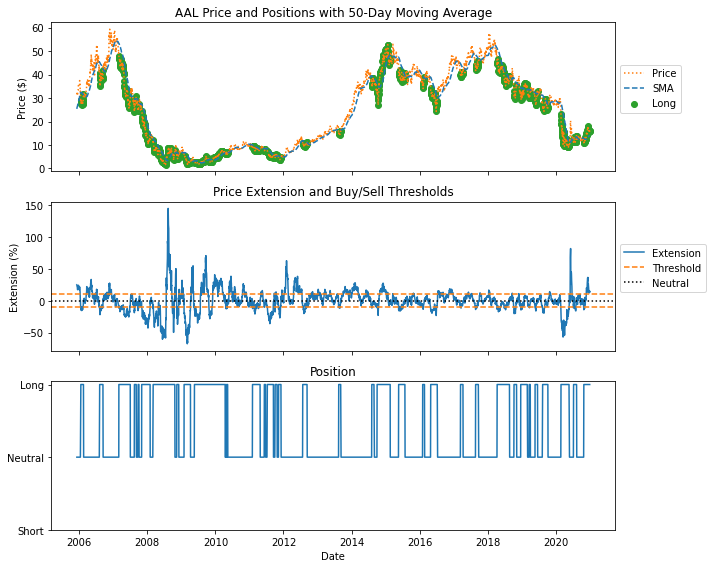

In [10]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(3, figsize=(10, 8), sharex=True)
long = data.loc[data['position']==1]['Close']
ax[0].plot(data['Close'], label='Price', linestyle=':', color=colors[1])
ax[0].plot(data['SMA'], label='SMA', linestyle='--', color=colors[0])
ax[0].scatter(long.index, long, label='Long', c=colors[2])
ax[0].legend(bbox_to_anchor=[1, 0.75])
ax[0].set_ylabel('Price ($)')
ax[0].set_title(f'{ticker} Price and Positions with {SMA}-Day Moving Average')
ax[1].plot(data['extension']*100, label='Extension', color=colors[0])
ax[1].axhline(threshold*100, linestyle='--', color=colors[1])
ax[1].axhline(-threshold*100, label='Threshold', linestyle='--', color=colors[1])
ax[1].axhline(0, label='Neutral', linestyle=':', color='k')
ax[1].set_title('Price Extension and Buy/Sell Thresholds')
ax[1].set_ylabel(f'Extension (%)')
ax[1].legend(bbox_to_anchor=[1, 0.75])
ax[2].plot(data['position'])
ax[2].set_xlabel('Date')
ax[2].set_title('Position')
ax[2].set_yticks([-1, 0, 1])
ax[2].set_yticklabels(['Short', 'Neutral', 'Long'])
plt.tight_layout()
plt.show()

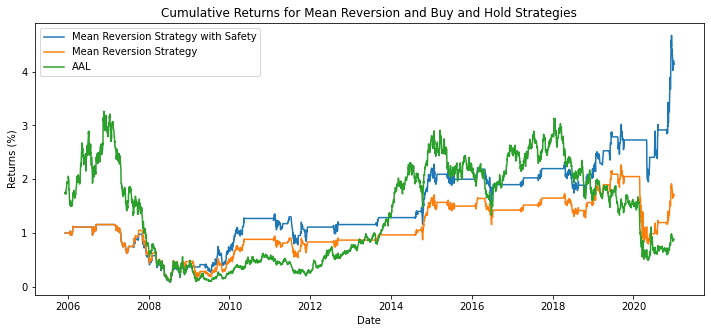

In [11]:
ticker = 'AAL'
SMA = 50
threshold = 0.1
safety_threshold = 0.15
shorts = False
data = SMAMeanReversion(ticker, SMA, threshold, shorts)
data_safe = SMAMeanReversionSafety(ticker, SMA, threshold, safety_threshold, shorts)
safe_stats_dict = getStratStats(data_safe)
df_safe_stats = pd.DataFrame(safe_stats_dict).round(3)
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_safe['strat_cum_returns'], label='Mean Reversion Strategy with Safety')
ax.plot(data['strat_cum_returns'], label='Mean Reversion Strategy')
ax.plot(data_safe['cum_returns'], label=f'{ticker}')
ax.set_xlabel('Date')
ax.set_ylabel('Returns (%)')
ax.set_title('Cumulative Returns for Mean Reversion and Buy and Hold Strategies')
ax.legend()
plt.show()

In [12]:
df_safe_stats.columns = ['Mean Reversion with Safety', 'Buy and Hold']
df_stats.columns = ['Mean Reversion', 'x']
df_stats = pd.concat([df_stats.T, df_safe_stats.T])
df_stats.drop('x', axis=0, inplace=True)
df_stats

,tot_returns,annual_returns,annual_volatility,sharpe_ratio,max_drawdown,max_drawdown_duration
Mean Reversion,0.721,0.037,0.542,0.031,1.467,2790.0
Mean Reversion with Safety,3.193,0.100,0.482,0.166,1.074,1280.0
Buy and Hold,-0.470,-0.041,0.687,-0.089,3.170,5150.0


<>:15: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:15: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-13-c0168a026467>:15: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  ax.set_xticklabels([i for i in calendar.month_abbr if i is not ''])


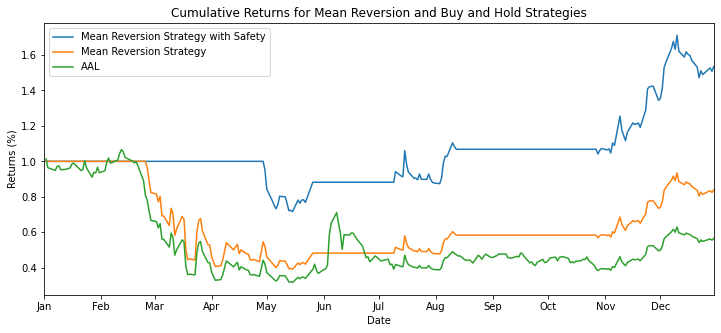

In [13]:
import calendar
ticks = [pd.to_datetime(f'2020-{i}-01') for i in np.arange(1, 13)]
cr_mr_safe = np.exp(data_safe.loc[data_safe.index>=ticks[0]]['strat_log_returns'].cumsum())
cr_mr = np.exp(data.loc[data.index>=ticks[0]]['strat_log_returns'].cumsum())
cr_base = np.exp(data.loc[data.index>=ticks[0]]['log_returns'].cumsum())
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(cr_mr_safe, label='Mean Reversion Strategy with Safety')
ax.plot(cr_mr, label='Mean Reversion Strategy')
ax.plot(cr_base, label=f'{ticker}')
ax.set_xlabel('Date')
ax.set_ylabel('Returns (%)')
ax.set_title('Cumulative Returns for Mean Reversion and Buy and Hold Strategies')
ax.set_xlim([pd.to_datetime('2020-01-01'), data.index[-1]])
ax.set_xticks(ticks)
ax.set_xticklabels([i for i in calendar.month_abbr if i is not ''])
ax.legend()
plt.show()

In [24]:
stats_dict = getStratStats(data, risk_free_rate=0.02)
pd.DataFrame(stats_dict).round(3)

,strat_stats,base_stats
tot_returns,0.663,-0.112
annual_returns,0.034,-0.008
annual_volatility,0.347,0.684
sharpe_ratio,0.040,-0.041
max_drawdown,1.154,3.170
max_drawdown_duration,2379.000,5150.000


In [22]:
spyObj = yf.Ticker('SPY')
spy_data = spyObj.history(start='2000-01-01', end='2020-12-31')
spy_ratio = spy_data['Close'][-1] / spy_data['Close'][0]
spy_ret = spy_ratio - 1
years = (spy_data.index[-1] - spy_data.index[0]).days / 365
spy_ann_ret = (spy_ratio) ** (1 / years) - 1
print(f'SPY Total Returns:\t{spy_ret*100:.2f}%' + 
      f'\nSPY Annual Returns:\t{spy_ann_ret*100:.2f}%')
      
print(f'SMA Total Returns:\t{stats_dict["strat_stats"]["tot_returns"]*100:.2f}%' +
      f'\nSMA Annual Returns:\t{stats_dict["strat_stats"]["annual_returns"]*100:.2f}%')

SPY Total Returns:	279.02%
SPY Annual Returns:	6.55%
SMA Total Returns:	72.07%
SMA Annual Returns:	3.67%


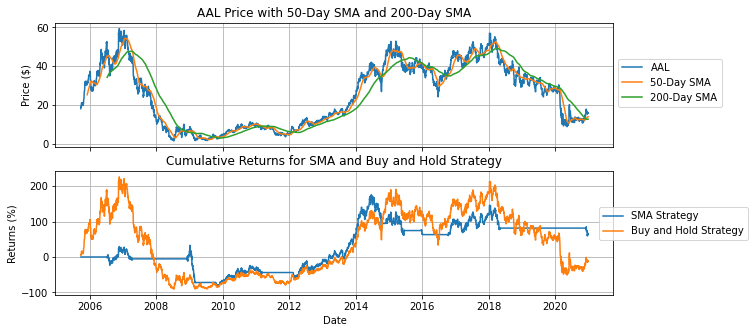

In [20]:
short_term_sma = 50
long_term_sma = 200
data = SMABacktest(ticker, short_term_sma, long_term_sma)
fig, ax = plt.subplots(2, figsize=(10, 5), sharex=True)
ax[0].plot(data['Close'], label=ticker)
ax[0].plot(data['SMA1'], label=f"{short_term_sma}-Day SMA")
ax[0].plot(data['SMA2'], label=f"{long_term_sma}-Day SMA")
ax[0].set_ylabel('Price ($)')
ax[0].set_title(f'{ticker} Price with {short_term_sma}-Day SMA and {long_term_sma}-Day SMA')
ax[0].legend(bbox_to_anchor=[1, 0.75])
ax[0].grid()
ax[1].plot((data['strat_cum_returns'] - 1) * 100, label='SMA Strategy')
ax[1].plot((data['cum_returns'] - 1) * 100, label='Buy and Hold Strategy')
ax[1].set_ylabel('Returns (%)')
ax[1].set_xlabel('Date')
ax[1].set_title(f'Cumulative Returns for SMA and Buy and Hold Strategy')
ax[1].legend(bbox_to_anchor=[1.25, 0.75])
ax[1].grid()
plt.show()

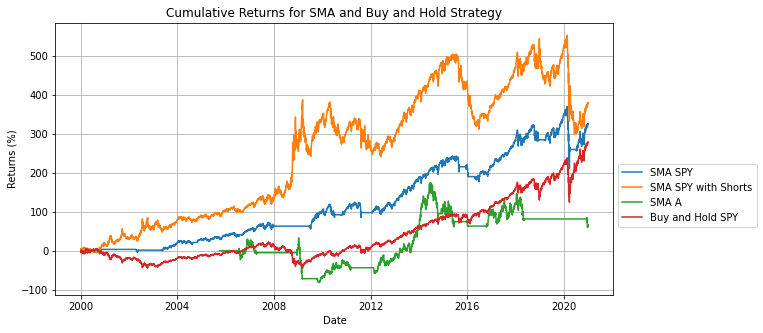

In [23]:
sma_spy_data = SMABacktest('spy', short_term_sma, \
    long_term_sma, shorts=False)
sma_spy_data_shorts = SMABacktest('spy', short_term_sma, \
    long_term_sma, shorts=True)
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax.plot((sma_spy_data['strat_cum_returns'] - 1) * 100, \
    label='SMA SPY')
ax.plot((sma_spy_data_shorts['strat_cum_returns'] - 1) * 100, \
    label='SMA SPY with Shorts')
ax.plot((data['strat_cum_returns'] - 1) * 100, \
    label='SMA A')
ax.plot((sma_spy_data['cum_returns'] - 1) * 100, \
    label='Buy and Hold SPY')
ax.set_ylabel('Returns (%)')
ax.set_xlabel('Date')
ax.set_title(f'Cumulative Returns for SMA and Buy and Hold Strategy')
ax.legend(bbox_to_anchor=[1, 0.5])
ax.grid()
plt.show()

In [25]:
spy_stats = getStratStats(sma_spy_data, risk_free_rate=0.02)
spy_stats_shorts = getStratStats(sma_spy_data_shorts, risk_free_rate=0.02)
df0 = pd.DataFrame(stats_dict)
df0.columns = ['A SMA', 'A Buy and Hold']
df1 = pd.DataFrame(spy_stats)
df1.columns = ['SPY SMA', 'base_strat']
df2 = pd.DataFrame(spy_stats_shorts)
df2.columns = ['SPY SMA with Shorts', 'SPY Buy and Hold']
df = pd.concat([df0, df1, df2], axis=1)
df.drop('base_strat', axis=1, inplace=True)
df.round(3)

,A SMA,A Buy and Hold,SPY SMA,SPY SMA with Shorts,SPY Buy and Hold
tot_returns,0.663,-0.112,3.264,3.796,2.790
annual_returns,0.034,-0.008,0.072,0.078,0.066
annual_volatility,0.347,0.684,0.127,0.199,0.199
sharpe_ratio,0.040,-0.041,0.408,0.290,0.229
max_drawdown,1.154,3.170,1.586,2.542,1.141
max_drawdown_duration,2379.000,5150.000,941.000,1695.000,2407.000
